In [5]:
import zipfile as zp
import pandas as pd
#from pypac import PACSession as Session #or use requests below if non-ONS
from requests import Session
from io import BytesIO
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Creating Summary Prescription Data for England

This code has been created to work with 2016, 2017 and 2018 data, earlier data may have format inconsistencies that need to be dealt with.

# Set File Location of Prescribing Data

These files are the "GP practice prescribing data - Presentation level" zip files that come from: https://data.gov.uk/dataset/176ae264-2484-4afe-a297-d51798eb8228/gp-practice-prescribing-data-presentation-level

In [6]:
# Path to zip files
# path = r"[CHANGE THIS PATH]\England\\"
path = r"england"

# Read in drug data

In [8]:
# Get drug data (NB some drugs duplicated for illnesses)
drug_data = pd.read_csv(path + r"/drug_list.csv")

In [9]:
drug_data

,illness,medication
0,depression,fluoxetine
1,depression,citalopram
2,depression,paroxetine
3,depression,sertraline
4,depression,dapoxetine
5,depression,escitalopram
6,depression,fluvoxamine
7,depression,duloxetine
8,depression,venlafaxine
9,depression,mirtazapine


# Process Prescribing Data

This code iterates over the monthly prescribing data, ultimately producing an aggregate table.

Note, if you want to find prescribing for non-loneliness relatived diseases, all you need to do is provide a different set of drug_data and edit the code_loneliness function.

In [5]:
# Function to find loneliness related prescribing
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x['BNF NAME'].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                  case=False, 
                                                  regex=True).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
    # Add loneliness related disease binary - avoids double counting some drugs.
    out['loneliness'] = x['BNF NAME'].str.contains("|".join(drug_data['medication'].unique()),
                                                   case = False, 
                                                   regex = True).astype('int16')
    # Return dataframe multiplied by counts of items.
    return out.multiply(x['ITEMS'], axis=0)

In [6]:
# Make dictionary for aggregation
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols['ITEMS'] = 'sum'
agg_cols['loneliness'] = 'sum'
for key in ['Date','SHA','PCT','pcstrip','CenterName','Street','Town','Town2','Postcode']:
    agg_cols[key] = 'first'

In [7]:
monthly_data = []

for file in os.listdir(path + '/zip'):
    with zp.ZipFile(path + '/zip/' + file) as zipf:
        zip_names = zipf.namelist()

        # Deal with Address Files
        addr_name = next((filename for filename in zip_names if "ADDR" in filename), None)
        # Open address file in pandas, set header.
        addr = pd.read_csv(zipf.open(addr_name), 
                           header=0, 
                           names = ["Date", "PracCode", "PracName","CenterName",
                                    "Street", "Town", "Town2", "Postcode"], 
                           usecols = range(8))

        # Deal with prescription info
        prescribe_name = next((filename for filename in zip_names if "PDPI" in filename), None)
        # Open prescribing files in pandas.
        prescribe = pd.read_csv(zipf.open(prescribe_name))
        prescribe.columns = prescribe.columns.str.strip()
        # Get counts of prescribing dataframe for loneliness related diseases
        loneliness_prescribing = code_loneliness(prescribe[['BNF NAME','ITEMS']])
        # merge dataframes
        prescribe = prescribe.merge(loneliness_prescribing, left_index=True, right_index=True)
        del loneliness_prescribing
        
        # merge in address information
        prescribe = prescribe.merge(addr, left_on = 'PRACTICE', right_on = 'PracCode')
        del addr
        
        # Create uniform postcode field
        prescribe['pcstrip'] = prescribe['Postcode'].str.replace("\s","")
        
        # get a summary - grouping by PracCode
        summary = prescribe.groupby('PracCode', as_index=False).agg(agg_cols)
        del prescribe
        
        monthly_data.append(summary)
        print(file)

<ipython-input-7-206450546c85>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  prescribe['pcstrip'] = prescribe['Postcode'].str.replace("\s","")


2015 02 Feb.zip
2015 09 Sept.zip
2015 06 Jun.zip
2015 10 Oct.zip
2015 07 Jul.zip
2015 01 Jan.zip
2015 04 Apr.zip
2015 11 Nov.zip
2015 05 May.zip
2015 12 Dec.zip
2015 08 Aug.zip
2015 03 Mar.zip


In [14]:
# concatenate all the monthly data together.
data = pd.concat(monthly_data, ignore_index = True)

In [15]:
# Save aggregated data
data.to_csv(path + "/processed_data.csv")

# Add Postcode Location

Postcode location is pulled in from the latest ONS NSPL (National Statistics Postcode Lookup). There is a guide to fields here: http://geoportal.statistics.gov.uk/datasets/0a404beab6f544be8fb72d0c2b12d62b

NB - If using an ONS laptop `pip install pypac`, if not comment pypac import above and use requests.

In [10]:
data = pd.read_csv(path + "/processed_data.csv", index_col=0)

In [11]:
# Read in postcode lookup data
# This is the persistent link to the latest ONS NSPL
postcode_url = "http://geoportal.statistics.gov.uk/datasets/055c2d8135ca4297a85d624bb68aefdb_0.csv"

with Session() as session:
    response = session.get(postcode_url, verify = False)

field_dtypes = {'objectid': 'int32', 'pcd':'str', 'pcd2': 'str', 'pcds':'str', 'dointr':'str','doterm':'str',
                'usertype':'int8','oseast1m': 'float', 'osnorth1m': 'float', 'osgrdind':'int8', 'lat':'float', 
                'long':'float', 'X':'float', 'Y':'float', 'imd': 'int8',
                'oa11':'str', 'cty': 'str', 'ced':'str', 'laua': 'str', 'ward': 'str', 'hlthau':'str',
                'ctry': 'str','pcon': 'str','eer': 'str','teclec': 'str','ttwa': 'str','pct': 'str','nuts': 'str',
                'park': 'str','lsoa11': 'str','msoa11': 'str','wz11': 'str','ccg': 'str','bua11': 'str',
                'buasd11': 'str','ru11ind': 'str','oac11': 'str','lep1': 'str','lep2': 'str','pfa': 'str',
                'ced': 'str','nhser': 'str','rgn': 'str','calncv': 'str','stp': 'str'}

#pc = pd.read_csv(BytesIO(response.content), dtype = field_dtypes)
pc = pd.read_csv(path + '/NSPL_AUG_2018_UK.csv', dtype=field_dtypes)

/home/davide/anaconda3/envs/Loneliness_study/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geoportal.statistics.gov.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [12]:
# create pcstrip for matching
pc['pcstrip'] = pc['pcd'].str.replace("\s","")

<ipython-input-12-f8a74b782d6c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pc['pcstrip'] = pc['pcd'].str.replace("\s","")


NB - here I'm joining 2011 LSOA, 2011 MSOA, Rural-Urban Indicator, Region (formally GOR), Local Authority Area (effectively district), and IMD score (NB separate for each country). However, you can add any of the geography codes available in the NSPL.

In [13]:
data_temp = data.merge(pc[['pcstrip','oseast1m','osnrth1m','lsoa11','msoa11','ru11ind','rgn','laua','imd']], 
                       how = 'left',
                       on = 'pcstrip')

In [14]:
data_temp

,PracCode,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,Town2,Postcode,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,laua,imd
0,A81002,1885,94,2725,2753,475,1912,37,0,31,...,CLEVELAND,TS18 2AW,444458.0,519543.0,E01012267,E02002548,C1,E12000001,E06000004,39.0
1,A81003,413,25,700,702,127,562,5,0,2,...,CLEVELAND,TS26 8DB,450539.0,532524.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0
2,A81004,740,19,963,977,188,754,132,0,11,...,CLEVELAND,TS1 3BE,449732.0,519892.0,E01012068,E02002496,C1,E12000001,E06000002,122.0
3,A81005,706,20,1399,1412,213,1064,27,0,25,...,,TS14 7DJ,461221.0,515668.0,E01012117,E02002532,C1,E12000001,E06000003,-86.0
4,A81006,1506,44,1885,1910,358,1622,17,0,15,...,CLEVELAND,TS18 2AT,444478.0,519481.0,E01012267,E02002548,C1,E12000001,E06000004,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118857,Y04937,22,0,0,0,0,0,6,0,1,...,LANCASHIRE,WN3 4NW,359363.0,404428.0,E01006309,E02001298,A1,E12000002,E08000010,1.0
118858,Y04963,0,0,0,0,0,0,0,0,0,...,,PE1 5DU,520005.0,298983.0,E01015612,E02003250,C1,E12000006,E06000031,21.0
118859,Y04970,0,0,0,0,0,0,0,0,0,...,LONDON,E9 6SR,535570.0,185336.0,E01001729,E02000363,A1,E12000007,E09000012,113.0
118860,Y04971,1,0,0,0,0,0,1,0,0,...,KENT,CT17 0HD,630445.0,142130.0,E01024240,E02005051,C1,E12000008,E07000108,78.0


In [15]:
# Check for missing postcodes
data_temp[data_temp['oseast1m'].isnull()]['pcstrip'].value_counts()

YO302JS    12
DL154SB    12
DN18QN     12
WR59QT     12
CV115PO    12
HU32AE     12
Y084ET     11
MK67JJ     11
HA24ES     11
TW152EA    11
GL10QD     10
E113JT      9
BS378NG     7
ME122TZ     7
BD106JE     6
LA284BY     4
DN156QV     4
Name: pcstrip, dtype: int64

In [16]:
# Clean Missing Postcodes - appear to be typos.
new_pcs = {'DL154SB': 'DL54SB', 'WR59QT':'WR52QT', 'DN18QN':'DN48QN', 'HU32AE':'HU34AE','GL10QD': 'GL13NN',
           'ME122TZ':'ME102TZ', 'BS378NG':'BS374NG', 'CV115PO':'CV115PQ', 'TW152EA':'TW153EA', 'EN24EJ':'EN80BX', 
           'YO302JS':'YO306JA','L62UN':'L67UN', 'NG698DB':'NG98DA', 'HA24ES':'HA14ES'}

data['pcstrip'] = data['pcstrip'].map(new_pcs).fillna(data['pcstrip'])

In [17]:
# Merge data
data = data.merge(pc[['pcstrip','oseast1m','osnrth1m','lsoa11','msoa11','ru11ind','rgn','laua','imd']], 
                  how = 'left', 
                  on = 'pcstrip')

In [18]:
# Save aggregated data
data.to_csv(path + "/processed_data_with_postcodes.csv")

## Check Postcodes 

Some Practice Codes have more than one postcode associated with them. Possible reasons for this are:
* Practices move to a new location.
* Practices are assigned a new postcode but don't physically move.
* Practice postcodes are wrongly entered at a particular wave and subsequently fixed.

There are 794 practices codes which have more than 1 postcode assigned to them, this is about 7% of unique practices.

764 for those practices have 2 postcodes associated with them, while 30 have 3 postcodes.

102 of these practices fall within the same LSOA, 669 fall within 2 different LSOAs, and 30 within 3 different LSOAs.

We'll ignore this for now - this will require some more advanced cleaning - useful to be aware of though.

In [19]:
data = pd.read_csv(path + '/processed_data_with_postcodes.csv')
# Check for 1 postcode per Practice Code
pc_prac_counts = data.groupby('PracCode')['pcstrip'].unique().map(len)
# 794 practices have more than 1 postcode associated with it.
pc_prac_counts[pc_prac_counts > 1].count()

238

In [20]:
# Practice codes with multiple associated postcodes account forc. 7% of the data
pc_prac_counts[pc_prac_counts > 1].count()/len(pc_prac_counts)

0.022508038585209004

In [21]:
pc_prac_counts[pc_prac_counts > 1].value_counts()

2    235
3      3
Name: pcstrip, dtype: int64

In [22]:
# Count of these Practices falling within the same LSOA
(data[data['PracCode'].isin(pc_prac_counts[pc_prac_counts > 1].index)]
 .groupby('PracCode')['lsoa11']
 .unique()
 .map(len)
 .value_counts())

2    201
1     35
3      2
Name: lsoa11, dtype: int64

# Subsetting the Data

## Use only General Practice surgeries

Use the 'Patients Registered at a GP Practice' data from: to get GP surgery codes and subset the data.

In [23]:
data = pd.read_csv(path + "/processed_data_with_postcodes.csv", index_col = 0)

In [24]:
# Get GP files
# gp_path = r"[CHANGE THIS PATH]\England\GP data\\"
gp_path = r"england/GP data/"

In [25]:
gp_combine = []

for file in os.listdir(gp_path):
    # read file into pandas
    month, year = file[-10:-4].split("-")
    
    # Deal with different file structures
    if (year == '15') or (year == '17' and month == 'jan'):
        gp_data = pd.read_csv(gp_path + file)
        gp_data['DATE'] = "01" + month.upper() + "20" + year
        gp_data.columns = gp_data.columns.str.upper()
        gp_data = gp_data.rename(columns = {'DATE':'Date','GP_PRACTICE_CODE':'PracCode','TOTAL_ALL':'NUMBER_OF_PATIENTS'})
        gp_combine.append(gp_data[['Date','PracCode','POSTCODE','NUMBER_OF_PATIENTS']])
    else:
        gp_data = pd.read_csv(gp_path + file)
        gp_data.columns = gp_data.columns.str.upper().str.replace(" ","_")
        gp_data = gp_data.rename(columns = {'EXTRACT_DATE':'Date', 'CODE':'PracCode'})
        if year == '17' and month == 'jun':
            gp_data['Date'] = "01" + month.upper() + "20" + year
        gp_combine.append(gp_data[['Date','PracCode','POSTCODE','NUMBER_OF_PATIENTS']])
    print(file)

gp-reg-pat-prac-all-dec-15.csv
gp-reg-pat-prac-all-jun-15.csv
gp-reg-pat-prac-all-mar-15.csv
gp-reg-pat-prac-all-sep-15.csv
gp-reg-pat-prac-all-oct-15.csv
gp-reg-pat-prac-all-nov-15.csv
gp-reg-pat-prac-all-jan-15.csv
gp-reg-pat-prac-all-jul-15.csv
gp-reg-pat-prac-all-may-15.csv
gp-reg-pat-prac-all-feb-15.csv
gp-reg-pat-prac-all-aug-15.csv
gp-reg-pat-prac-all-apr-15.csv


In [26]:
# concatenate all the gp data together.
gp_data = pd.concat(gp_combine, ignore_index = True)

In [27]:
# Get the unique codes for GP surgeries and subset the prescribing data according to these codes.
gp_ids = gp_data['PracCode'].unique()
data = data[data['PracCode'].isin(gp_ids)].copy()
data.shape

(93607, 29)

In [28]:
# Make date a datetime variable
gp_data['Date'] = pd.to_datetime(gp_data['Date'], format = '%d%b%Y')

In [29]:
# Make date a datetime variable - days are assigned as first day of the month.
data['Date'] = pd.to_datetime(data['Date'], format = '%Y%m')

In [30]:
gp_data[1:10]

,Date,PracCode,POSTCODE,NUMBER_OF_PATIENTS
1,2015-12-01,A81002,TS18 2AW,19667
2,2015-12-01,A81003,TS26 8DB,3379
3,2015-12-01,A81004,TS1 3BE,9090
4,2015-12-01,A81005,TS14 7DJ,7896
5,2015-12-01,A81006,TS18 2AT,12283
6,2015-12-01,A81007,TS24 7PW,9720
7,2015-12-01,A81008,TS6 6TD,4045
8,2015-12-01,A81009,TS5 6HF,9207
9,2015-12-01,A81011,TS24 7PW,11371


In [31]:
data[1:10]

,PracCode,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,Town2,Postcode,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,laua,imd
1,A81003,413,25,700,702,127,562,5,0,2,...,CLEVELAND,TS26 8DB,450539.0,532524.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0
2,A81004,740,19,963,977,188,754,132,0,11,...,CLEVELAND,TS1 3BE,449732.0,519892.0,E01012068,E02002496,C1,E12000001,E06000002,122.0
3,A81005,706,20,1399,1412,213,1064,27,0,25,...,,TS14 7DJ,461221.0,515668.0,E01012117,E02002532,C1,E12000001,E06000003,-86.0
4,A81006,1506,44,1885,1910,358,1622,17,0,15,...,CLEVELAND,TS18 2AT,444478.0,519481.0,E01012267,E02002548,C1,E12000001,E06000004,39.0
5,A81007,943,33,1049,1084,176,835,2,0,3,...,CLEVELAND,TS24 7PW,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0
6,A81008,517,8,971,991,145,850,157,0,0,...,CLEVELAND,TS6 6TD,453885.0,519863.0,E01033470,E02006910,C1,E12000001,E06000003,-104.0
7,A81009,1137,35,1434,1455,298,1017,77,0,4,...,CLEVELAND,TS5 6HF,449131.0,518827.0,E01012078,E02002500,C1,E12000001,E06000002,107.0
8,A81011,1279,35,1471,1485,220,1082,30,0,9,...,CLEVELAND,TS24 7PW,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0
9,A81012,734,13,788,795,178,571,21,0,12,...,,TS3 6AL,450757.0,519893.0,E01012059,E02002497,C1,E12000001,E06000002,59.0


In [32]:
# Merge on the basis of date and PracCode - produces some nulls for counts.
# It may be possible to predict missing values using a time-series model.
data = data.merge(gp_data, how = 'left', on = ['Date','PracCode'])
# data = data.merge(gp_data, how = 'left', on = ['PracCode'])

In [33]:
# Save aggregated data
data.to_csv(path + "/processed_data_with_postcodes_GPs.csv")

# Generate Statistics from Prescribing Counts

## Percentages At Postcode Level

Aggregate observations to postcodes and compute percentages for 'depression', 'alzheimers', 'blood pressure', 'hypertension', 'diabetes', 'cardiovascular disease', 'insomnia', 'addiction', 'social anxiety', and 'loneliness'.

## Outlier Removal

Should we remove some GPs on the basis that they have very low/high values which might indicate they are not accessible to the general population, and instead represent specialist services?

Currently, we won't do this, but it's an advanced task to look into.

## Standardise Percentages

Should we standardise within time points, or across them? Or standardise with GP practices or across them?

Can't standardize within GPs, as can't then compare between GPs.

Can't standardise across GPs within years, as can't then compare between years.

Can't standardise across GPs across years, as can't then disambiguate changes to rank order over time.

<u> First Step </u>

Take the average percentage of disease groups within postcodes annually - this is then an annual summary measure of prescribing by postcode. Aggregation entire depends on desired time frame for analysis.

NB, this is a mean of percentages - could also calculate an overall percentage by summing monthly counts by year and dividing through by monthly sum of items.

<u> Second Step </u>

z-score standardise for earliest year observed across GPs. Store mean and standard deviation.

z-score standardise subsequent years wrt baseline mean and standard deviation.

OR

Use min-max normalisation by year (decile normalisation?). This standardises the different percentages to the same range - although in theory they're comparable anyway...

## Aggregation and Percentages

In [34]:
data = pd.read_csv(path + "/processed_data_with_postcodes_GPs.csv", index_col = 0)

In [35]:
data[1:10]

,PracCode,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,laua,imd,POSTCODE,NUMBER_OF_PATIENTS
1,A81003,413,25,700,702,127,562,5,0,2,...,450539.0,532524.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0,TS26 8DB,3470.0
2,A81004,740,19,963,977,188,754,132,0,11,...,449732.0,519892.0,E01012068,E02002496,C1,E12000001,E06000002,122.0,TS1 3BE,9078.0
3,A81005,706,20,1399,1412,213,1064,27,0,25,...,461221.0,515668.0,E01012117,E02002532,C1,E12000001,E06000003,-86.0,TS14 7DJ,7918.0
4,A81006,1506,44,1885,1910,358,1622,17,0,15,...,444478.0,519481.0,E01012267,E02002548,C1,E12000001,E06000004,39.0,TS18 2AT,12204.0
5,A81007,943,33,1049,1084,176,835,2,0,3,...,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0,TS24 7PW,9520.0
6,A81008,517,8,971,991,145,850,157,0,0,...,453885.0,519863.0,E01033470,E02006910,C1,E12000001,E06000003,-104.0,TS6 6TD,4127.0
7,A81009,1137,35,1434,1455,298,1017,77,0,4,...,449131.0,518827.0,E01012078,E02002500,C1,E12000001,E06000002,107.0,TS5 6HF,9249.0
8,A81011,1279,35,1471,1485,220,1082,30,0,9,...,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0,TS24 7PW,11216.0
9,A81012,734,13,788,795,178,571,21,0,12,...,450757.0,519893.0,E01012059,E02002497,C1,E12000001,E06000002,59.0,TS3 6AL,4730.0


In [36]:
# Make dictionary for aggregation
# counts to sum
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols['ITEMS'] = 'sum'
agg_cols['loneliness'] = 'sum'
agg_cols['NUMBER_OF_PATIENTS'] = 'sum'

# Other data to preserve
for key in ['SHA','PCT','Street','Town','Town2','Postcode','oseast1m', 'osnrth1m',
            'lsoa11', 'msoa11','ru11ind', 'rgn', 'laua', 'imd']:
    agg_cols[key] = 'first'

In [37]:
# Do aggregation and produce counts by postcode by date.
data = data.groupby(['pcstrip','Date'], as_index=False).agg(agg_cols)

In [38]:
# Generate percentages
perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

# Percentages for discrete illness groups
data[target_cols] = data[perc_cols].divide(data['ITEMS'], axis=0) * 100

# Overall percentage for loneliness realted disease prescribing
data['loneliness_perc'] = data['loneliness'].divide(data['ITEMS'], axis=0) * 100

## Standardisation (z-scores)

In [40]:
data[1:10]

,pcstrip,Date,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,...,depression_perc,alzheimers_perc,blood pressure_perc,hypertension_perc,diabeties_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc,loneliness_perc
1,AL100BS,2015-02-01,658,3,1197,1225,182,783,54,4,...,4.528562,0.020647,8.238128,8.430833,1.252581,5.388851,0.371645,0.027529,0.055058,20.020647
2,AL100BS,2015-03-01,659,5,1272,1301,222,810,50,4,...,4.405964,0.033429,8.504379,8.698268,1.484255,5.415525,0.334292,0.026743,0.073544,20.398476
3,AL100BS,2015-04-01,734,5,1258,1292,227,828,58,5,...,4.702717,0.032035,8.059969,8.277806,1.454382,5.304972,0.371604,0.032035,0.076884,20.175551
4,AL100BS,2015-05-01,694,5,1321,1345,220,851,52,4,...,4.580253,0.032999,8.718321,8.876716,1.451954,5.616420,0.343189,0.026399,0.072598,20.927930
5,AL100BS,2015-06-01,695,8,1235,1268,225,816,52,4,...,4.417186,0.050845,7.849244,8.058981,1.430024,5.186221,0.330494,0.025423,0.057201,19.499174
6,AL100BS,2015-07-01,771,10,1405,1442,253,913,51,5,...,4.637594,0.060150,8.451128,8.673684,1.521805,5.491729,0.306767,0.030075,0.054135,20.721805
7,AL100BS,2015-08-01,696,6,1241,1270,214,833,55,4,...,4.648057,0.040069,8.287699,8.481368,1.429144,5.562976,0.367303,0.026713,0.073461,20.555630
8,AL100BS,2015-09-01,707,5,1326,1354,217,878,54,0,...,4.452982,0.031492,8.351704,8.528059,1.366757,5.530012,0.340115,0.000000,0.069283,20.249417
9,AL100BS,2015-10-01,783,9,1370,1394,252,933,63,0,...,4.739996,0.054483,8.293480,8.438767,1.525516,5.648042,0.381379,0.000000,0.048429,20.788183


In [41]:
# Firstly aggregate percentages by postcodes by year.
#data['Year'] = data['Date'].dt.year
data['Year'] = 2015

# Aggregation
cols = {'NUMBER_OF_PATIENTS': 'mean', 'SHA':'first', 'PCT':'first', 'oseast1m':'first', 'osnrth1m':'first',
        'lsoa11': 'first', 'msoa11': 'first', 'ru11ind': 'first', 'rgn': 'first', 'laua':'first', 'imd': 'first',
        'depression_perc': 'mean', 'alzheimers_perc': 'mean', 'blood pressure_perc': 'mean', 'hypertension_perc': 'mean',
        'diabeties_perc': 'mean', 'cardiovascular disease_perc': 'mean', 'insomnia_perc': 'mean', 'addiction_perc': 'mean',
        'social anxiety_perc': 'mean', 'loneliness_perc': 'mean'}

data = data.groupby(['pcstrip','Year'], as_index=False).agg(cols)

In [42]:
# The mean value returns a value broadly in the centre of the distribution of respective disease classes.
# Therefore we'll go with an un-truncated arithmetic mean.
# Can always revisit this assumption later.

per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc', 'loneliness_perc']

# Get mean and std for baseline (2016)
mean_std = data[data['Year'] == 2015][per_cols].agg(['mean','std'])

In [43]:
# Make new column names.
std_cols = [col[:-4] + 'zscore' for col in per_cols]

zscores = []    
# z-score standardise for each year by baseline mean and std 
for year in [2015,2016,2017,2018]:
    zscores.append((data.loc[data['Year'] == year, per_cols] - mean_std.loc['mean', per_cols]) / mean_std.loc['std', per_cols])

zscores = pd.concat(zscores).sort_index()
data[std_cols] = zscores

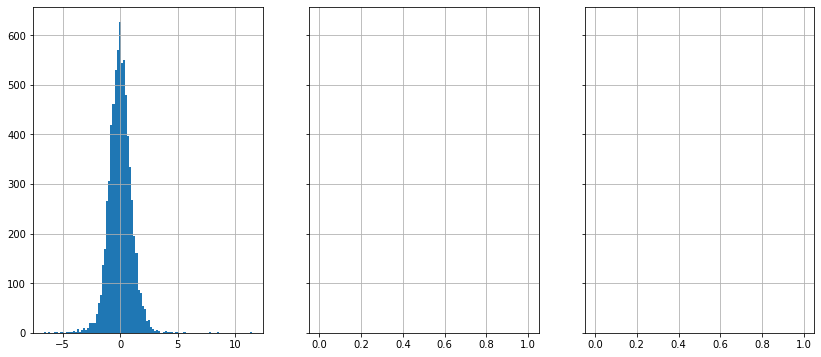

In [44]:
# plot zscores for loneliness
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,6), sharey = True)

# Note that there appears to be increasing variation in lonelines prescribing over time.
# These means are comparable as standardised using 2016 mean and std.
data[data['Year'] == 2015]['loneliness_zscore'].hist(bins=100, ax = ax1)
data[data['Year'] == 2017]['loneliness_zscore'].hist(bins=100, ax = ax2)
data[data['Year'] == 2018]['loneliness_zscore'].hist(bins=100, ax = ax3);

In [45]:
# Save aggregated data
data.to_csv(path + "/processed_data_with_postcodes_GPs_stats.csv")

# Create Loneliness Variable

The actual loneliness variable we work with is the sum of the standardised scores of: depression, alzheimers, hypertension, insomnia, addiction and social anxiety, for each year of interest.

This means that the loneliness variable is actually an equally weighted index of the above domains.

In [48]:
# sum function ignores NAs
data['loneills'] =  data[['depression_zscore', 'alzheimers_zscore', 'hypertension_zscore', 'insomnia_zscore',
                          'addiction_zscore','social anxiety_zscore']].sum(axis=1)

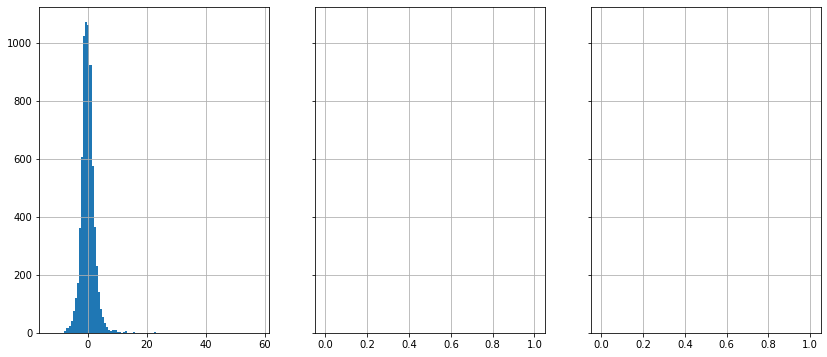

In [50]:
# plot zscores for loneills
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,6), sharey = True)

# Note that there appears to be increasing variation in lonelines prescribing over time.
data[data['Year'] == 2015]['loneills'].hist(bins=100, ax = ax1)
data[data['Year'] == 2017]['loneills'].hist(bins=100, ax = ax2)
data[data['Year'] == 2018]['loneills'].hist(bins=100, ax = ax3);

In [51]:
# Save aggregated data
data.to_csv(path + "/final_data.csv")